
## Painter Style Transfer


In [1]:
## !pip install config
## !pip install data


In [2]:

import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn as nn
import torch.optim as optim
import os
import torchvision.utils as vutils
import torch.nn.functional as F

from config import *
from torch.utils.data import DataLoader
from data import *
from PIL import Image

    

In [3]:

DATASET_DIR  = "datasets"
DATASET_NAME = "vangogh2photo"
STYLES       = ["ce", "mo", "uk", "vg"]

LOAD_DIM = 286
CROP_DIM = 256
CKPT_DIR = "checkpoints"
SAMPLE_DIR = "samples"


# Quadratic Potential
LAMBDA = 10.0
NORM   = "l1"

# CycleGAN++
CYC_WEIGHT = 10.0
ID_WEIGHT  = 0.5

# Network
N_CHANNELS = 3
UPSAMPLE   = True

# Training
RANDOM_SEED = 12345
BATCH_SIZE  = 4
LR          = 2e-4
BETA1       = 0.5
BETA2       = 0.999
BEGIN_ITER  = 0
END_ITER    = 15000
TRAIN       = False    # `False` runs `infer` function & `True` runs `train` function



# Inference
INFER_ITER    = 15000
INFER_STYLE   = "vg"
IMG_NAME      = "sun_flower.jpg"
IN_IMG_DIR    = "images"
OUT_STY_DIR   = "sty"
OUT_REC_DIR   = "rec"
IMG_SIZE      = None  # If `None` then stylizes original size `IMG_NAME`


# Logs
ITERS_PER_LOG  = 100
ITERS_PER_CKPT = 1000



In [4]:



# Set up `TRAIN_STYLE`
if DATASET_NAME == "cezanne2photo":
    TRAIN_STYLE = "ce"
elif DATASET_NAME == "monet2photo":
    TRAIN_STYLE = "mo"
elif DATASET_NAME == "ukiyoe2photo":
    TRAIN_STYLE = "uk"
elif DATASET_NAME == "vangogh2photo":
    TRAIN_STYLE = "vg"
    
    
DATASET_PATH = {
    "trainA": f"./{DATASET_DIR}/{DATASET_NAME}/trainA",
    "trainB": f"./{DATASET_DIR}/{DATASET_NAME}/trainB",
    "testA":  f"./{DATASET_DIR}/{DATASET_NAME}/testA",
    "testB":  f"./{DATASET_DIR}/{DATASET_NAME}/testB"
}




## GAN neural nets

In [5]:

class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.main = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels,  out_channels, 3, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(out_channels, out_channels, 3, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Initialize the weights with Xavier Glorot technique
        self.params_init()

    def params_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, x):
        return x + self.main(x)  # skip connection


In [6]:



class ConvTranspose2d(nn.Module):
    """
    Odena, et al., 2016. Deconvolution and Checkerboard Artifacts. Distill.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, upsample=None, output_padding=1):
        super(ConvTranspose2d, self).__init__()
        self.upsample = upsample
        if upsample:
            self.scale_factor = 4

        self.upsample_layer = F.interpolate
        reflection_pad = kernel_size // 2
        self.reflection_pad = nn.ConstantPad2d(reflection_pad, value=0)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, bias=False)
        self.convtrans2d = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=False)

        # Initialize the weights with Xavier Glorot technique
        self.params_init()

    def params_init(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, x):
        if self.upsample:
            return self.conv2d(self.reflection_pad(self.upsample_layer(x, scale_factor=self.scale_factor)))
        else:
            return self.convtrans2d(x)





In [7]:


class Generator(nn.Module):

    def __init__(self, dim=64, n_blocks=9, upsample=None):
        super(Generator, self).__init__()

        self.encoder_block = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(N_CHANNELS,   dim * 1, 7, 1,    bias=False),
            nn.BatchNorm2d(dim),
            nn.ReLU(inplace=True),

            # Downsampling layers
            nn.Conv2d(dim * 1,      dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.ReLU(inplace=True),

            nn.Conv2d(dim * 2,      dim * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.ReLU(inplace=True)
        )

        # Residual layers
        self.transform_block = nn.Sequential()
        for i in range(n_blocks):
            self.transform_block.add_module(str(i), ResidualBlock(dim * 4, dim * 4))

        # Upsampling layers
        self.decoder_block = nn.Sequential(
            ConvTranspose2d(dim * 4, dim * 2, upsample=upsample),
            nn.BatchNorm2d(dim * 2),
            nn.ReLU(inplace=True),

            ConvTranspose2d(dim * 2, dim * 1, upsample=upsample),
            nn.BatchNorm2d(dim * 1),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(dim, N_CHANNELS, 7, 1),
            nn.Tanh()
        )

        # Initialize the weights with Xavier Glorot technique
        self.params_init()

    def params_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, x):
        x = self.encoder_block(x)
        x = self.transform_block(x)
        x = self.decoder_block(x)
        return x




In [8]:



class Critic(nn.Module):

    def __init__(self, dim=64):
        super(Critic, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(N_CHANNELS,   dim * 1, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            # Increase number of filters with layers
            nn.Conv2d(dim * 1,      dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(dim * 2,      dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(dim * 4,      dim * 8, 4, 1, 1, bias=False),
            nn.BatchNorm2d(dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(dim * 8, 1, 4, 1, 1)
        )

        # Initialize the weights with Xavier Glorot technique
        self.params_init()

    def params_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
    
    def forward(self, x):
        return self.main(x)


## The data

In [9]:

def load_data():

    # Preprocessing
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(LOAD_DIM),
        transforms.RandomCrop(CROP_DIM),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
    ])

    # Make datasets
    X_folder = dsets.ImageFolder(DATASET_PATH["trainA"], transform=transform)
    Y_folder = dsets.ImageFolder(DATASET_PATH["trainB"], transform=transform)
    
    # Make dataset loaders
    X_set = DataLoader(X_folder, batch_size=BATCH_SIZE, shuffle=True)
    Y_set = DataLoader(Y_folder, batch_size=BATCH_SIZE, shuffle=True)
    
    # Print length of sample batches
    print("Dataset Details")
    print(f"X_set batches: {len(X_set)}")
    print(f"Y_set batches: {len(Y_set)}")
    print("")

    # Return the datasets
    return X_set, Y_set


In [10]:


def get_infinite_X_data(X_set):
    while True:
        for x, _ in X_set:
            yield x


In [11]:

def get_infinite_Y_data(Y_set):
    while True:
        for y, _ in Y_set:
            yield y


In [12]:


# There's some problem with batch size 
# of sampled data using `torchvision`.
# 
# This block of code tries to 
# eliminate the problem.

def safe_sampling(X_data, Y_data, device):

    # First sample the data
    x_sample, y_sample = next(X_data), next(Y_data)
    
    # Check requirement conditions
    # and sample next accordingly.
    if x_sample.size(0) != BATCH_SIZE:  # condition for `x_sample`
        print(f"Batch size not equal to that of x_sample: {BATCH_SIZE} != {x_sample.size(0)} | skipping...")
        x_sample = next(X_data)
    if y_sample.size(0) != BATCH_SIZE:  # condition for `y_sample`
        print(f"Batch size not equal to that of y_sample: {BATCH_SIZE} != {y_sample.size(0)} | skipping...")
        y_sample = next(Y_data)
    
    # Return correct data
    return x_sample.to(device), y_sample.to(device)


## Bash script to download the data

In [13]:

'''

FILE=$1

if [[ $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" ]]; then
    echo "Downloadable datasets: monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo"
    exit 1
fi

mkdir datasets
echo "Specified [$FILE]"
URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE


'''


'\n\nFILE=$1\n\nif [[ $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" ]]; then\n    echo "Downloadable datasets: monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo"\n    exit 1\nfi\n\nmkdir datasets\necho "Specified [$FILE]"\nURL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip\nZIP_FILE=./datasets/$FILE.zip\nTARGET_DIR=./datasets/$FILE/\nwget -N $URL -O $ZIP_FILE\nmkdir $TARGET_DIR\nunzip $ZIP_FILE -d ./datasets/\nrm $ZIP_FILE\n\n\n'


## Make directories 


In [14]:



try:
    if TRAIN:
        # Checkpoint directories
        if not os.path.exists(CKPT_DIR):
            os.mkdir(CKPT_DIR)
        for style in STYLES:
            if not os.path.exists(os.path.join(CKPT_DIR, style)):
                os.mkdir(os.path.join(CKPT_DIR, style))
    else:
        # Sample directories
        if not os.path.exists(SAMPLE_DIR):
            os.mkdir(SAMPLE_DIR)
        
        for style in STYLES:
            if not os.path.exists(os.path.join(SAMPLE_DIR, style)):
                os.mkdir(os.path.join(SAMPLE_DIR, style))
                # Make three directories
                os.mkdir(os.path.join(SAMPLE_DIR, style, OUT_STY_DIR))  # Stylized images here
                os.mkdir(os.path.join(SAMPLE_DIR, style, OUT_REC_DIR))  # Reconstructed images here
except:
    print("Directories already exist!")
    

## Load the dataset

In [15]:

if TRAIN:
    # Make experiments reproducible
    _ = torch.manual_seed(RANDOM_SEED)
    
    # Load the datasets
    X_set, Y_set = load_data()

    # Load infinite data
    X_data = get_infinite_X_data(X_set)
    Y_data = get_infinite_Y_data(Y_set)


## Initialize GAN

Define device, neural nets, losses, optimizers, etc.

In [16]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


C_X = Critic().to(device)   # Criticizes X data
C_Y = Critic().to(device)   # Criticizes Y data

G = Generator(upsample=UPSAMPLE).to(device) # Translates X -> Y
F = Generator(upsample=UPSAMPLE).to(device) # Translates Y -> X

# Losses
l1_loss = nn.L1Loss()

# Optimizers
C_X_optim = optim.Adam(C_X.parameters(), lr=LR, betas=(BETA1, BETA2))
C_Y_optim = optim.Adam(C_Y.parameters(), lr=LR, betas=(BETA1, BETA2))
G_optim =   optim.Adam(G.parameters(),   lr=LR, betas=(BETA1, BETA2))
F_optim =   optim.Adam(F.parameters(),   lr=LR, betas=(BETA1, BETA2))


In [17]:



def train():

    # Status
    print("Begin training!")

    # Load the checkpoints from `BEGIN_ITER`
    try:
        # Get checkpoint paths
        g_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"G_{BEGIN_ITER}.pth")
        f_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"F_{BEGIN_ITER}.pth")
        c_x_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_X_{BEGIN_ITER}.pth")
        c_y_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_Y_{BEGIN_ITER}.pth")

        # Load parameters from checkpoint paths
        G.load_state_dict(torch.load(g_model_path,     map_location=device))
        F.load_state_dict(torch.load(f_model_path,     map_location=device))
        C_X.load_state_dict(torch.load(c_x_model_path, map_location=device))
        C_Y.load_state_dict(torch.load(c_y_model_path, map_location=device))
        
        # Status
        print(f"Training: Loaded the checkpoints from {BEGIN_ITER}th iteration.")
    except:
        # Status
        print(f"Training: Couldn't load the checkpoints from {BEGIN_ITER}th iteration.")

    # Now finally begin training!
    for i in range(BEGIN_ITER, END_ITER + 1):
        
        # Sample safely
        x, y = safe_sampling(X_data, Y_data, device)

        #################
        # Train Critics #
        #################

        # Update gradient computation:
        # ∙ 👎 Generators
        # ∙ 👍 Critics
        for param in G.parameters():
            param.requires_grad_(False)
        for param in F.parameters():
            param.requires_grad_(False)
        for param in C_X.parameters():
            param.requires_grad_(True)
        for param in C_Y.parameters():
            param.requires_grad_(True)

        for j in range(2):

            # Forward passes:
            # ∙ X -> Y
            # ∙ Y -> X

            # Domain translation: X -> Y
            with torch.no_grad():
                G_x = G(x)      # G(x),     X -> Y
            C_Y_G_x = C_Y(G_x)  # Cy(G(x)), fake score
            C_y_y = C_Y(y)      # Cy(y),    real score

            # Domain translation: Y -> X
            with torch.no_grad():
                F_y = F(y)      # F(y),     Y -> X
            C_X_F_y = C_X(F_y)  # Cx(F(y)), fake score
            C_X_x = C_X(x)      # Cx(x),    real score

            # Zerofy the gradients
            C_X_optim.zero_grad()
            C_Y_optim.zero_grad()

            # Compute the losses:
            # ∙ QP-div loss (critizing x data),     Y -> X
            # ∙ QP-div loss (critizing y data),     X -> Y

            # QP-div loss (critizing x data)
            x_loss = C_X_x - C_X_F_y    # real score - fake score
            if NORM == "l1":
                x_norm = LAMBDA * (x - F_y).abs().mean()
            elif NORM == "l2":
                x_norm = LAMBDA * ((x - F_y)**2).mean().sqrt()
            x_loss = -x_loss + 0.5 * x_loss**2 / x_norm
            x_loss = x_loss.mean()

            # QP-div loss (critizing y data)
            y_loss = C_y_y - C_Y_G_x    # real score - fake score
            if NORM == "l1":
                y_norm = LAMBDA * (y - G_x).abs().mean()
            elif NORM == "l2":
                y_norm = LAMBDA * ((y - G_x)**2).mean().sqrt()
            y_loss = -y_loss + 0.5 * y_loss**2 / y_norm
            y_loss = y_loss.mean()

            # Total loss
            c_loss = x_loss + y_loss

            # Compute gradients
            c_loss.backward()

            # Update the networks
            C_Y_optim.step()
            C_X_optim.step()

        ####################
        # Train Generators #
        ####################

        # Update gradient computation:
        # ∙ 👍 Generators
        # ∙ 👎 Critics
        for param in G.parameters():
            param.requires_grad_(True)
        for param in F.parameters():
            param.requires_grad_(True)
        for param in C_X.parameters():
            param.requires_grad_(False)
        for param in C_Y.parameters():
            param.requires_grad_(False)

        for j in range(1):

            # Forward passes:
            # ∙ X -> Y
            # ∙ Y -> X
            # ∙ X -> Y -> X
            # ∙ Y -> X -> Y

            # Domain translation: X -> Y
            G_x = G(x)          # G(x),     X -> Y
            C_Y_G_x = C_Y(G_x)  # Cy(G(x)), fake score
            C_y_y = C_Y(y)      # Cy(y),    real score

            # Domain translation: Y -> X
            F_y = F(y)          # F(y),     Y -> X
            C_X_F_y = C_X(F_y)  # Cx(F(y)), fake score
            C_X_x = C_X(x)      # Cx(x),    real score

            # Cycle-consistent translations
            F_G_x = F(G_x)      # F(G(x)), X -> Y -> X
            G_F_y = G(F_y)      # G(F(y)), Y -> X -> Y

            # Zerofy the gradients
            G_optim.zero_grad()
            F_optim.zero_grad()

            # Compute the losses:
            # ∙ QP-div loss (critizing x data),     Y -> X
            # ∙ QP-div loss (critizing y data),     X -> Y
            # ∙ Cycle-consistency loss,             || F(G(x)) - x || L1
            # ∙ Cycle-consistency loss,             || G(F(y)) - y || L1
            # ∙ Identity loss,                      || G(x) - y || L1
            # ∙ Identity loss,                      || F(y) - x || L1
            
            # QP-div losses
            x_loss = C_X_x - C_X_F_y        # real score - fake score
            y_loss = C_y_y - C_Y_G_x        # real score - fake score
            x_loss = x_loss.mean()
            y_loss = y_loss.mean()

            # Cycle-consistency losses
            x_cyc_loss = l1_loss(F_G_x, x)  # || F(G(x)) - x || L1
            y_cyc_loss = l1_loss(G_F_y, y)  # || G(F(y)) - y || L1
            x_cyc_loss = x_cyc_loss.mean()
            y_cyc_loss = y_cyc_loss.mean()
            
            # Identity losses
            x_id_loss = l1_loss(G_x, y)     # || G(x) - y || L1
            y_id_loss = l1_loss(F_y, x)     # || F(y) - x || L1
            x_id_loss = x_id_loss.mean()
            y_id_loss = y_id_loss.mean()

            # Total loss
            g_loss = x_loss + y_loss
            g_loss += CYC_WEIGHT * (x_cyc_loss + y_cyc_loss)
            g_loss += ID_WEIGHT * (x_id_loss + y_id_loss)

            # Compute gradients
            g_loss.backward()

            # Update the networks
            G_optim.step()
            F_optim.step()

        #############
        # Log stats #
        #############

        if i % ITERS_PER_LOG == 0:
            # Status
            print(f"iter: {i} c_loss: {c_loss} g_loss: {g_loss}")

        if i % ITERS_PER_CKPT == 0:
            # Get checkpoint paths
            g_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"G_{i}.pth")
            f_model_path =   os.path.join(CKPT_DIR, TRAIN_STYLE, f"F_{i}.pth")
            c_x_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_X_{i}.pth")
            c_y_model_path = os.path.join(CKPT_DIR, TRAIN_STYLE, f"C_Y_{i}.pth")

            # Save the checkpoints
            torch.save(G.state_dict(),   g_model_path)
            torch.save(F.state_dict(),   f_model_path)
            torch.save(C_X.state_dict(), c_x_model_path)
            torch.save(C_Y.state_dict(), c_y_model_path)

            # Status
            print(f"Saved checkpoints at {i}th iteration.")
    # Status
    print("Finished Training!")





In [18]:



def infer(iteration, style, img_name, in_img_dir, out_rec_dir, out_sty_dir, img_size=None):
    
    # Set neural nets to evaluation mode
    G.eval()
    F.eval()

    # Try loading models from checkpoints at `iteration`
    try:
        # Get checkpoint paths
        g_model_path = os.path.join(CKPT_DIR, style, f"G_{iteration}.pth")
        f_model_path = os.path.join(CKPT_DIR, style, f"F_{iteration}.pth")
        
        # Load parameters from checkpoint paths
        G.load_state_dict(torch.load(g_model_path, map_location=device))
        F.load_state_dict(torch.load(f_model_path, map_location=device))
        
        # Status
        print(f"Inference: Loaded the checkpoints from {iteration}th iteration.")
    except:
        # Status
        print(f"Inference: Couldn't load the checkpoints from {iteration}th iteration.")
        raise

    # Minor transforms
    if img_size == None:
        loader = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
        ])
    else:
        loader = transforms.Compose([
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
        ])

    from PIL import Image

    def image_loader(image_name):
        image = Image.open(image_name)
        image = loader(image).unsqueeze(0)  # Add a fake batch dimension
        return image.to(device, torch.float)
    
    # style_a = image_loader(out_img_path)
    in_img_path = os.path.join(in_img_dir, img_name)
    in_img = image_loader(in_img_path)
    
    with torch.no_grad():
        print("Stylization")
        sty_img = F(in_img)     # Y -> X
        print("Reconstruction")
        rec_img = G(sty_img)    # X -> Y
    
    # WARNING: Please do not change this code snippet with a closed mind. 🤪👻
    iteration = int(iteration / 1000)
    only_img_name = img_name.split('.')[0]
    img_type = img_name.split('.')[1]

    # Set up names
    out_sty_name = f"sty_{only_img_name}_{style}_{iteration}k.{img_type}"
    out_rec_name = f"rec_{only_img_name}_{style}_{iteration}k.{img_type}"
    
    # Set up paths
    sty_path = os.path.join(SAMPLE_DIR, style, out_sty_dir, out_sty_name)
    rec_path = os.path.join(SAMPLE_DIR, style, out_rec_dir, out_rec_name)
    
    # Save image grids
    vutils.save_image(sty_img, sty_path, normalize=True)
    vutils.save_image(rec_img, rec_path, normalize=True)
    
    # Status
    print(f"Saved {rec_path}")
    print(f"Saved {sty_path}")



In [20]:

IMG_NAME      = "PNW_input_image.jpg"
INFER_STYLE   = "mo"

if __name__ == "__main__":
    
    if TRAIN:
        train()
    else:
        infer(
            iteration=INFER_ITER,
            style=INFER_STYLE,
            img_name=IMG_NAME,
            in_img_dir=IN_IMG_DIR,
            out_rec_dir=OUT_REC_DIR,
            out_sty_dir=OUT_STY_DIR,
            img_size=IMG_SIZE
        )


Inference: Loaded the checkpoints from 15000th iteration.
Stylization
Reconstruction
Saved samples/mo/rec/rec_PNW_input_image_mo_15k.jpg
Saved samples/mo/sty/sty_PNW_input_image_mo_15k.jpg


## Original image

In [21]:


def image_loader(image_name):
    image = Image.open(image_name)
    return image


In [22]:
img1 = image_loader('images/PNW_input_image.jpg')

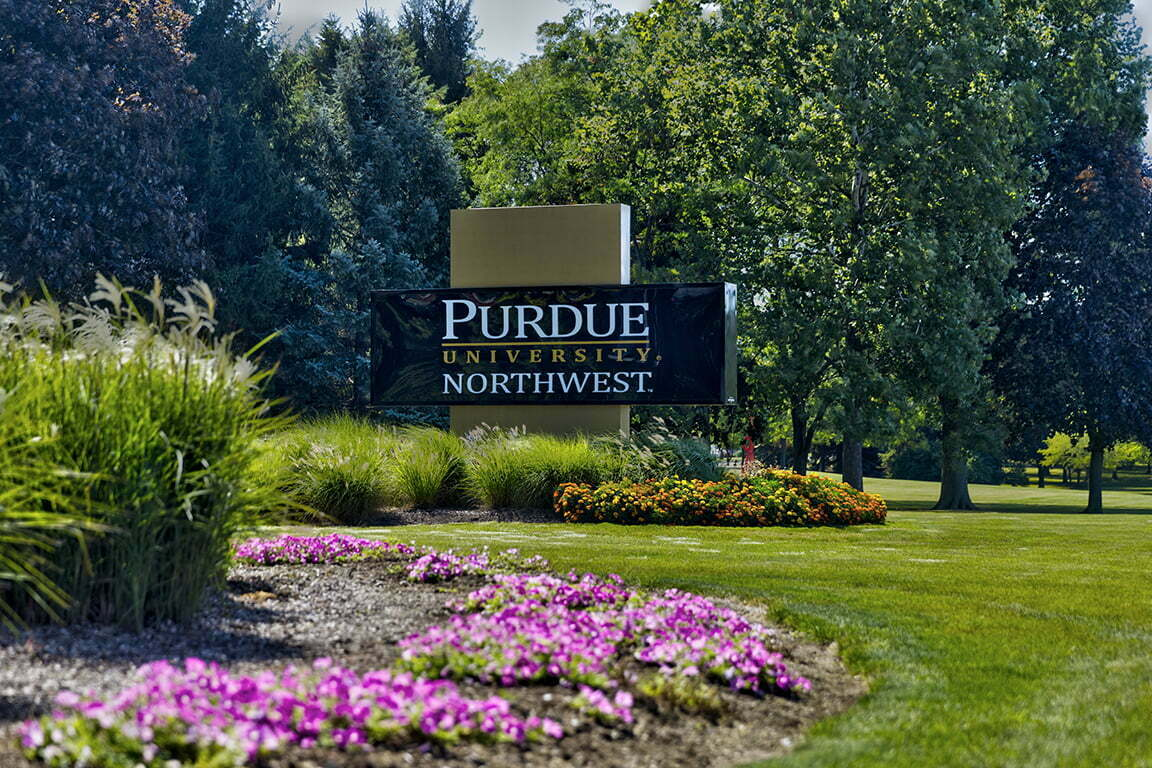

In [23]:
img1

## Vangoh

In [24]:

img1_vg = image_loader('samples/vg/sty/sty_PNW_input_image_vg_15k.jpg')


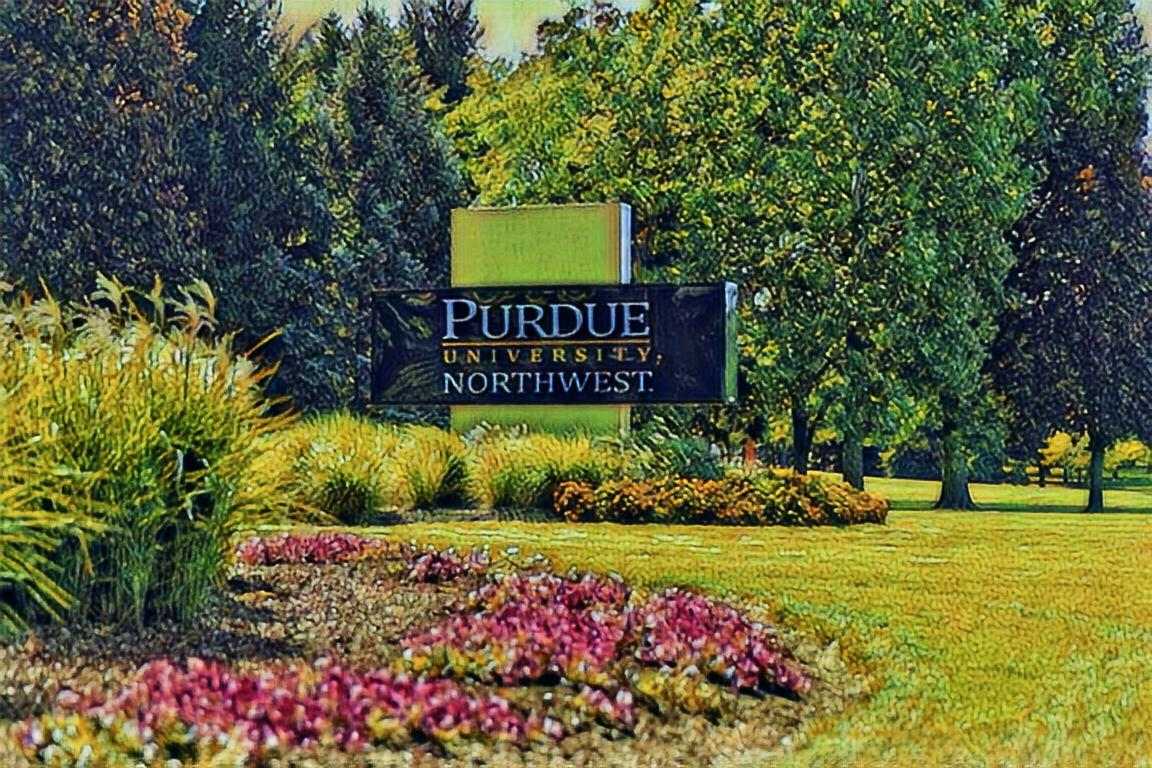

In [25]:
img1_vg

## Monet

In [26]:

img1_mo = image_loader('samples/mo/sty/sty_PNW_input_image_mo_15k.jpg')


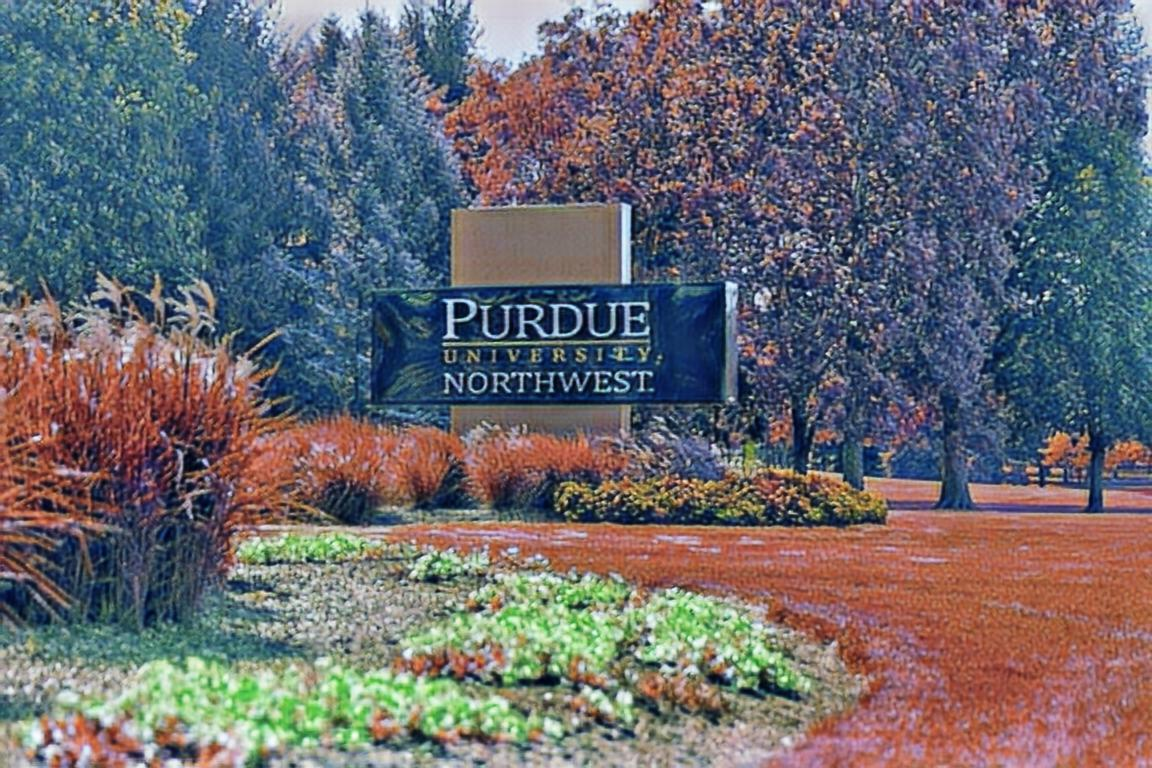

In [27]:
img1_mo